# Хакатон ЯП-R1

**Описание задачи**

Цель этого соревнования - разработка модели склонности (бинарной классификации) к покупке клиентом оборудования после коммуникации с ним в одном из каналов. 

Для Компании необходимо оценивать вероятность покупки Клиентом определённого товара, и, на основании прогноза, планировать маркетинговую стратегию: например, людям, которые не склонны к покупке товара (в данном случае ТВ-приставка), вообще не звонить и не предлагать.

Датасет собран для случайного множества клиентов ('id' – идентификатор клиента), с которыми была
попытка коммуникации в одном из каналов ('channel_name').

Целевая переменная ('target') равна единице, если после коммуникации с клиентом была продажа
оборудования и нулю если нет.

Поле 'period' соответствует месяцу сбора признаков на клиента. Лаг между датой коммуникации и сборкой признаков на клиента: 2 месяца, поэтому, если коммуникация была в марте (любой день), то признаки на клиента собирались на 31 января.

Представлены 2 датасета: dataset_train.parquet (с целевой переменной) и dataset_oot.parquet
(отложенная выборка без целевой переменной)

**Файлы**

* dataset_train.parquet - тренировочный датасет;
* features_oot.parquet - тестовый датасет;
* features_types.json - описание типов признаков;
* sample_submission.csv- пример файла с загружаемыми результатами.

**Признаки**

Для каждой пары 'id' + 'period' собрано более 2500 признаков
Названия признаков интерпретируются следующим образом:

**<модуль><номер признака><глубина агрегации>_<тип>**

Если признак построен как агрегат (например сумма за период), то указывается <глубина агрегации> в
месяцах, в противном случае ставится 0. Также, в качестве <глубина агрегации> может быть запись вида
'3d6', что указывает на отношение агрегата за 3 месяца к агрегату за 6 месяцев.

Различные типы признаков (<тип>) описаны ниже:

* flg - флаг (значение 1 или 0)
* ctg - категориальный признак
* num - числовой признак
* dt - дата
* cnt -количество
* sum -сумма
* avg - среднее
* sumpct -персентиль по сумме
* part - доля

В файле features_types.json дополнительно записан словарь, где для каждой фичи в соответствие ставится тип из списка (numeric, categorical_int, categorical_string)

# План работы

* импорт инструментария,
* загрузка данных,
* ознакомление с данными,
* отбор обучающих признаков,
* выбор и обучение финальных моделей,
* анализ важности ее признаков,
* выгрузка тестовых прогнозов

# Импорт инструментария

In [1]:
import pandas as pd
import numpy as np 

import pyarrow.parquet as pq
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle 

import lightgbm as lgb
import catboost
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt 
import seaborn as sns 

from tqdm import tqdm

#настройка отображения данных в таблицах
#максимальное количество строк
pd.set_option('display.max_rows',500)
#максимальное количество колонок
pd.set_option('display.max_columns',200)
#максимальное количество символов в ячейке
pd.set_option('display.max_colwidth',200)
    

Ниже ячейка с созданными нами дополнительными функциями.

In [2]:
#Создание функции downsample для корректирования дисбаланса классов
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=234)
    
    return features_downsampled, target_downsampled

#Создание функци для уменьшения занимаемой данными памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object)&(col_type != 'category'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Импорт данных

## Файл с именами столбцов

In [3]:
#импорт датафрейма с названиями колонн и типом данных
cols = pd.read_json('/kaggle/input/r1-hack/features_types.json',orient='index')
#сохранение названий столбцов в отдельный список
cols_ind=list(cols.index)
#добавление названия целевого признака в список с названиями столбцов
cols_ind.append('target')

## Тренировочный датасет

In [4]:
#Загрузка первой строки
pf = ParquetFile('/kaggle/input/r1-hack/dataset_train.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 1)) 
df_train = pa.Table.from_batches([first_ten_rows]).to_pandas() 

#Загрузка всех строк по батчам
parquet_file = pq.ParquetFile('/kaggle/input/r1-hack/dataset_train.parquet')

for batch in tqdm(parquet_file.iter_batches()):
    
    batch_df = batch.to_pandas()
    for col in batch_df.columns:
        if batch_df[col].dtypes=='float64':
            batch_df[col]=pd.to_numeric(batch_df[col],downcast='float')
               
    df_train=pd.concat([df_train,batch_df])

11it [02:44, 14.97s/it]


In [5]:
%%time
#сокращение используемой памяти
df_train=reduce_mem_usage(df_train)

Memory usage of dataframe is 13002.23 MB
Memory usage after optimization is: 3737.93 MB
Decreased by 71.3%
CPU times: user 38.3 s, sys: 579 ms, total: 38.9 s
Wall time: 38.6 s


## Тестовый датасет

In [6]:
#число загружаемых колонок 
n_cols=100
#число загружаемых строк
n_rows=10

#импорт части тестовых данных из общего датасета
df_test=pd.read_parquet('/kaggle/input/r1-hack/features_oot.parquet',columns=cols_ind[0:n_cols])[0:n_rows]

## Пример выгружаемых данных

In [7]:
#импорт датасета с примером выходных данных
df_sample=pd.read_csv('/kaggle/input/r1-hack/sample_submission.csv')

# Ознакомление с данными

## Датасет с именами столбцов

In [8]:
#корректировка количества выводимых строк
pd.set_option('display.max_rows',3550)
#вывод названий столбцов
print(cols)
pd.set_option('display.max_rows',300)

                                                   0
markers_0_1_cnt                              numeric
markers_1_1_cnt                              numeric
markers_2_1_cnt                              numeric
markers_3_1_cnt                              numeric
markers_4_1_cnt                              numeric
markers_5_1_cnt                              numeric
markers_6_1_cnt                              numeric
markers_7_1_cnt                              numeric
markers_8_1_cnt                              numeric
markers_9_1_cnt                              numeric
markers_10_1_cnt                             numeric
markers_11_1_cnt                             numeric
markers_12_1_cnt                             numeric
markers_13_1_cnt                             numeric
markers_14_1_cnt                             numeric
markers_15_1_cnt                             numeric
markers_16_1_cnt                             numeric
markers_17_1_cnt                             n

In [9]:
#вывод уникальных значений по типу данных в столбцах
print('уникальные типы данных:',cols[0].unique())

#вывод числа столбцов с типом данных numeric
print('количество числовых признаков:',len(cols[cols[0]=='numeric']))

#вывод числа столбцов с типом данных categorical_str
print('количество категорий-текстов:',len(cols[cols[0]=='categorical_str']))

#вывод числа столбцов с типом данных categorical_int
print('количество категорий-чисел:',len(cols[cols[0]=='categorical_int']))

уникальные типы данных: ['numeric' 'categorical_str' 'categorical_int']
количество числовых признаков: 2607
количество категорий-текстов: 31
количество категорий-чисел: 138


По названиям столбцов можно выделить несколько групп (в порядке их положения в json-файле):


|Обозначение признака|Расшифровка|
|-------|---------|
|**markers_0_1_cnt...markers_805_1_cnt**|  806 признаков модуля markers_<номер признака от 0 до 805>_<глубина агрегации=1 месяц>_<тип cnt - количество>, тип данных - numeric. **Предположение: это какие-то агрегированные маркеры, соответствующие поведению пользователя, агрегированные помесячно и посчитанные в количество**|
|**spas_symptoms_agr_0_1_std...spas_symptoms_agr_19_6_sum**|  некоторое количество признаков модуля spas_symptoms_agr_<номер признака от 0 до 19>_<глубина агрегации 1,3,6,12 месяцев>_<тип std,sum,avg>, тип данных - numeric **Предположение: это уже какие-то расчётные величины, симптомы поведения пользователей, агрегированные по разным периодам и по стандартному отклонению, сумме, среднему**|
|**materials_details_0_1_ctg**|  один категориальный признак, который агрегирован за месяц и **связан, видимо, с какими-то материалами:)**, тип данных - categorical_str|
|**communication_availability_0_1_flg**|  один категориальный признак, видимо характеризует **доступность клиента к коммуникации**, тип - flag, тип данных - categorial_int| 
|**payments_details_0_1_cnt...payments_details_29_6_sumpct**|  некоторое количество признаков **с информацией об оплате**, агрегированный по разным периодам (1,3,6 месяцев), тип cnt,avg,sum,sumpct, тип данных - numeric|
|**user_devices_0_1_cnt, communication_availability_1_1_ctg**|  видимо блок для **тех юзеров, у которых нет девайсов и есть какая-то коммуникативная доступность**, типы данных numeric и categorial_int соответственно|
|**user_devices_1_1_cnt, communication_availability_2_1_flg, materials_details_1_1_ctg, user_lifetime_0_1_ctg, user_lifetime_1_1_flg**|  видимо блок описывающий **юзеров с 1 девайсом, как они доступны, их юзерское состояние** - есть путаница с нумерацией признаков, возможно смысл несколько иной, типы данных - numeric, categorical_int, categorical_str|
|далее ещё один такой блок, с различным числом столбцов materal details||
|**arpu_0_1_sum...arpu_2_6_avg**|  из википедии: "показатель, используемый телекоммуникационными компаниями и означающий средний доход в расчёте на одного абонента. Является одним из показателей, характеризующих успешность бизнеса компании. Общемировым является тренд на снижение ARPU.", видимо суммарный и средний по 3,6 месяцев, тип данных - numeric|
|**balance_details_0_1_num**|  признак с деталями о балансе, тип данных - numeric|
|**charges_details_0_1_sum...charges_details_32_6_avg**| признаки с информацией о сборах, агргированные по 1,3,6 месяцев, тип данных - numeric|
|**tariff_plans_2_1_num...tariff_plans_7_1_num**|информация о тарифных планах, тип данных numeric|
|**payments_details_30_1_sum...payments_details_50_6_sum**|снова информация об оплатах,тип данных numeric |
|**plan_costs_0_1_sum...plan_costs_8_6_avg**|планируемые затраты?, тип данных numeric|
|**vas_details_0_1_sum...vas_details_44_6_sum**|какая-то метрика, тип данных numeric|
|**social_dem_0_0_flg**|какая-то метрика, тип данных categorial_int|
|В общем дальше будут только метрики с новыми названиями, тк некоторые названия начали повторяться (но другие номера пошли)||
|**smarttv_age...**|признаки, как-то связывающие возраст и наличие(?) смарт-тв|
|**spas_symptoms_int**|признаки, характеризующие поведение клиента относительно интернет-услуг|
|**spas_symptoms_iptv**|признаки, характеризующие поведение клиента относительно ip телевидения|
|**spas_symptoms_tv**|признаки, характеризующие поведение клиента относительно телевидения (аналогового?)|
|**spas_symptoms_ott**|признаки, характеризующие поведение клиента относительно предоставления видеоуслуг через интернет (возможно онлайн-кинотеатры), тип данных numeric|
|**area_0_0_num**|какая-то метрика, тип данных numeric|
|**traffic_details**|признаки, характеризующие траффик пользователя, тип данных numeric|
|**scheme_types**|какие-то признаки, тип данных categorial int|
|**movix_channels**|признаки, характеризующие поведение клиента относительно системы movix, тип данных - numeric|
|**info_house**|какие-то признаки, тип данных categorial int|
|**deact_react**|признаки, показывающие реакцию клиента на деактивацию?, тип данных-categorial_str|
|**exist_tariff_**|существует ли тариф?, тип данных - categorial_int|
|**spas_symptoms_agr**|какие-то агрегированные симптомы поведения пользователя, тип данных - numeric|
|**issues**|признаки, характеризующие различные проблемы пользователя, тип данных - numeric|
|**online_cinema**|признаки, конкретно по онлайн-кинотеатрам,numeric|
|**cities..**|похоже, город, тип данных - categorial_str|
|**save_team_answers**|ответы команды техподдержки?, numeric|
|**migrant_**|какие-то признаки по миграциям клиентов, categorial_int|
|**movix_app_visits**|признаки связанные с приложениями в системе movix, numeric|
|**basic_info**|признаки с какой-то базовой информацией, numeric|
|**type_av_100**|характеристика аналогового телевидения?, numeric|
|**agreement_type**|тип соглашения, categorical_str|
|**autopay_**|признаки, связанные с автоплатежом, numeric, categorial_str|
|**campaigns_**|признаки, связанные с рекламными кампаниями?, numeric|
|**domru_site_**|признаки, завязанные на сайте, numeric|


## Тренировочный датасет

In [10]:
#вывод информации методом info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702087 entries, 0 to 46725
Columns: 2780 entries, id to communication_availability_69_1_flg
dtypes: category(2), float16(2587), float64(20), int16(10), int32(8), int8(153)
memory usage: 3.7 GB


In [11]:
#подсчёт числа пропусков в процентах
pd.DataFrame(round(df_train.isna().mean()*100,),columns=['% пропусков']).style.background_gradient('coolwarm')

,% пропусков
id,0.000000
period,0.000000
channel_name,0.000000
target,0.000000
markers_0_1_cnt,4.000000
markers_1_1_cnt,4.000000
markers_2_1_cnt,4.000000
markers_3_1_cnt,4.000000
markers_4_1_cnt,4.000000
markers_5_1_cnt,4.000000


In [12]:
#вывод информации методом describe для первых 1000 строк
df_train[:1000].describe()

,period,target,markers_0_1_cnt,markers_1_1_cnt,markers_2_1_cnt,markers_3_1_cnt,markers_4_1_cnt,markers_5_1_cnt,markers_6_1_cnt,markers_7_1_cnt,markers_8_1_cnt,markers_9_1_cnt,markers_10_1_cnt,markers_11_1_cnt,markers_12_1_cnt,markers_13_1_cnt,markers_14_1_cnt,markers_15_1_cnt,markers_16_1_cnt,markers_17_1_cnt,markers_18_1_cnt,markers_19_1_cnt,markers_20_1_cnt,markers_21_1_cnt,markers_22_1_cnt,markers_23_1_cnt,markers_24_1_cnt,markers_25_1_cnt,markers_26_1_cnt,markers_27_1_cnt,markers_28_1_cnt,markers_29_1_cnt,markers_30_1_cnt,markers_31_1_cnt,markers_32_1_cnt,markers_33_1_cnt,markers_34_1_cnt,markers_35_1_cnt,markers_36_1_cnt,markers_37_1_cnt,markers_38_1_cnt,markers_39_1_cnt,markers_40_1_cnt,markers_41_1_cnt,markers_42_1_cnt,markers_43_1_cnt,markers_44_1_cnt,markers_45_1_cnt,markers_46_1_cnt,markers_47_1_cnt,markers_48_1_cnt,markers_49_1_cnt,markers_50_1_cnt,markers_51_1_cnt,markers_52_1_cnt,markers_53_1_cnt,markers_54_1_cnt,markers_55_1_cnt,markers_56_1_cnt,markers_57_1_cnt,markers_58_1_cnt,markers_59_1_cnt,markers_60_1_cnt,markers_61_1_cnt,markers_62_1_cnt,markers_63_1_cnt,markers_64_1_cnt,markers_65_1_cnt,markers_66_1_cnt,markers_67_1_cnt,markers_68_1_cnt,markers_69_1_cnt,markers_70_1_cnt,markers_71_1_cnt,markers_72_1_cnt,markers_73_1_cnt,markers_74_1_cnt,markers_75_1_cnt,markers_76_1_cnt,markers_77_1_cnt,markers_78_1_cnt,markers_79_1_cnt,markers_80_1_cnt,markers_81_1_cnt,markers_82_1_cnt,markers_83_1_cnt,markers_84_1_cnt,markers_85_1_cnt,markers_86_1_cnt,markers_87_1_cnt,markers_88_1_cnt,markers_89_1_cnt,markers_90_1_cnt,markers_91_1_cnt,markers_92_1_cnt,markers_93_1_cnt,markers_94_1_cnt,markers_95_1_cnt,markers_96_1_cnt,markers_97_1_cnt,...,communication_availability_31_1_flg,communication_availability_33_1_flg,scheme_types_0_1_flg,scheme_types_1_1_flg,scheme_types_2_1_flg,scheme_types_3_1_flg,scheme_types_4_1_flg,communication_availability_34_1_flg,communication_availability_35_1_ctg,communication_availability_36_1_flg,user_active_1_1_flg,communication_availability_37_1_flg,tariff_plans_15_src_id,communication_availability_38_1_flg,communication_availability_39_1_flg,communication_availability_40_1_ctg,communication_availability_41_1_flg,communication_availability_42_1_ctg,communication_availability_43_1_flg,communication_availability_44_1_flg,deact_react_0_1_ctg,materials_details_9_1_flg,materials_details_10_1_flg,materials_details_11_1_flg,materials_details_12_1_flg,info_house_3_0_flg,info_house_4_0_flg,info_house_7_0_flg,info_house_8_0_flg,info_house_9_0_flg,user_active_3_1_flg,exist_tariff_0_1_flg,deact_react_3_1_ctg,tariff_plans_17_src_id,communication_availability_45_1_flg,user_active_4_1_flg,exist_tariff_1_1_flg,tariff_plans_19_src_id,deact_react_8_1_ctg,communication_availability_46_1_flg,communication_availability_47_1_flg,communication_availability_48_1_flg,communication_availability_49_1_flg,communication_availability_50_1_flg,user_active_5_1_flg,exist_tariff_2_1_flg,deact_react_13_1_ctg,tariff_plans_24_src_id,communication_availability_51_1_flg,communication_availability_52_1_flg,communication_availability_53_1_flg,communication_availability_54_1_flg,migrant_0_1_flg,communication_availability_55_1_flg,user_active_6_1_flg,communication_availability_56_1_ctg,communication_availability_57_1_ctg,materials_details_20_1_flg,materials_details_22_1_flg,materials_details_23_1_flg,communication_availability_58_1_flg,communication_availability_59_1_flg,communication_availability_60_1_flg,user_active_7_1_flg,user_active_8_1_flg,user_active_9_1_flg,user_active_10_1_flg,user_active_11_1_flg,user_active_12_1_flg,user_active_13_1_flg,user_active_14_1_flg,user_active_15_1_flg,user_active_16_1_flg,user_active_17_1_flg,user_active_18_1_flg,user_active_19_1_flg,user_active_20_1_flg,user_active_21_1_flg,user_active_29_1_flg,user_active_30_1_flg,user_active_31_1_flg,user_active_32_1_flg,user_active_33_1_flg,user_active_34_1_flg,communication_availability_61_1_flg,communication_availability_62_1_flg,communication_availability_63_1

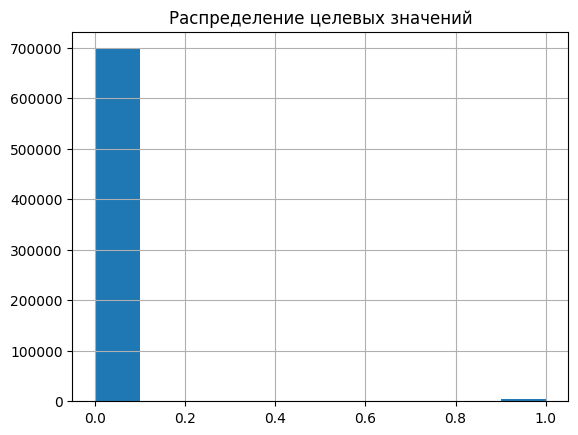

Соотношение целевых классов: 0.007789632908742079


In [13]:
df_train['target'].hist()
plt.title('Распределение целевых значений')
plt.show()
print('Соотношение целевых классов:',df_train['target'].mean())

Отсюда видно, что во многих столбцах присутствуют пропуски. Следовательно, в дальнейшем будем использовать соотвествтующие модели (бустинги) или заполнять пропуски (спойлер: заполнение пропусков различными способами: KNN, медианы и проч, ухудшали метрики оценки качества моделей).

Аналогично и с выбросами. 

Стоит отметить наличие дисбаланса классов, в связи с чем в дальнейшем использовали downsample.

# Отбор обучающих признаков

Идея состоит в следующем: 
* берём модель бустинга LGBM 
* обучаем её на всех признаках (даунсемплом корректируя дисбаланс) 
* выбираем методом feature_importance влияющие признаки (те для которых величина больше нуля) 
* выгружаем только эти признаки
* снова обучаем модель
* подбираем гиперпараметры
* выгружаем прогноз

Затем делаем то же самое с моделью CatBoost, выбираем лучшее и грузим прогноз.


## Модель LGBM

In [14]:
#выделение таргета
target=df_train['target']
#удаляем из обучающих признаков таргет и id как потенциально не влияющий признак
df_train=df_train.drop(columns=['target','id'])

In [15]:
%%time
#выборка строк
N=800000
features=df_train[:N]
target=target[:N]

CPU times: user 7.53 ms, sys: 1.75 ms, total: 9.29 ms
Wall time: 8.57 ms


In [16]:
%%time
#применение функции уменьшения класса к увеличенному классу
features_downsampled, target_downsampled = downsample(features, target, 0.05)
#проверка соотношения классов
print('размер оубчающей выборки:',features.shape)
print('баланс классов:', target_downsampled.mean())
print('')
print('размер даунсемпловой выборки:',features_downsampled.shape)



#разделение выборок
X_train, X_test, y_train, y_test= train_test_split(features_downsampled,
                                                   target_downsampled, 
                                                   test_size=.2,random_state=234,
                                                   stratify=target_downsampled)

размер оубчающей выборки: (702087, 2778)
баланс классов: 0.13570719602977668

размер даунсемпловой выборки: (40300, 2778)
CPU times: user 20.9 s, sys: 9.53 ms, total: 20.9 s
Wall time: 21 s


In [17]:
%%time
#это была не первая итерация всех этих действий, потому гиперпараметры уже подобраны
booster_1 = lgb.LGBMClassifier(learning_rate=0.02,
                             num_leaves=13,
                             max_depth=7,
                             max_bin=120,
                             num_iterations=400,
                             random_state=234)
booster_1.fit(X_train, y_train, eval_set=[(X_test, y_test),],
            eval_metric='auc',
            early_stopping_rounds=6)
y_pred_lgbm=booster_1.predict_proba(X_test)
y_pred_lgbm=y_pred_lgbm[:,1]
print('lgbm:',roc_auc_score(y_test, y_pred_lgbm))

[1]	valid_0's auc: 0.728532	valid_0's binary_logloss: 0.395286
[2]	valid_0's auc: 0.728608	valid_0's binary_logloss: 0.393536
[3]	valid_0's auc: 0.732932	valid_0's binary_logloss: 0.391909
[4]	valid_0's auc: 0.733147	valid_0's binary_logloss: 0.390369
[5]	valid_0's auc: 0.733654	valid_0's binary_logloss: 0.38886
[6]	valid_0's auc: 0.734633	valid_0's binary_logloss: 0.387435
[7]	valid_0's auc: 0.735389	valid_0's binary_logloss: 0.386105
[8]	valid_0's auc: 0.736724	valid_0's binary_logloss: 0.384787
[9]	valid_0's auc: 0.737011	valid_0's binary_logloss: 0.383552
[10]	valid_0's auc: 0.740061	valid_0's binary_logloss: 0.382329
[11]	valid_0's auc: 0.740999	valid_0's binary_logloss: 0.381185
[12]	valid_0's auc: 0.74071	valid_0's binary_logloss: 0.380197
[13]	valid_0's auc: 0.741409	valid_0's binary_logloss: 0.379121
[14]	valid_0's auc: 0.741913	valid_0's binary_logloss: 0.37809
[15]	valid_0's auc: 0.742014	valid_0's binary_logloss: 0.377177
[16]	valid_0's auc: 0.741962	valid_0's binary_loglos

In [18]:
#выгрузка важных признаков
fe_0=pd.DataFrame(booster_1.feature_importances_,df_train.columns)
fe_0=fe_0[fe_0[0]>0]

len(fe_0)

fe_0.to_csv('fe_0.csv')

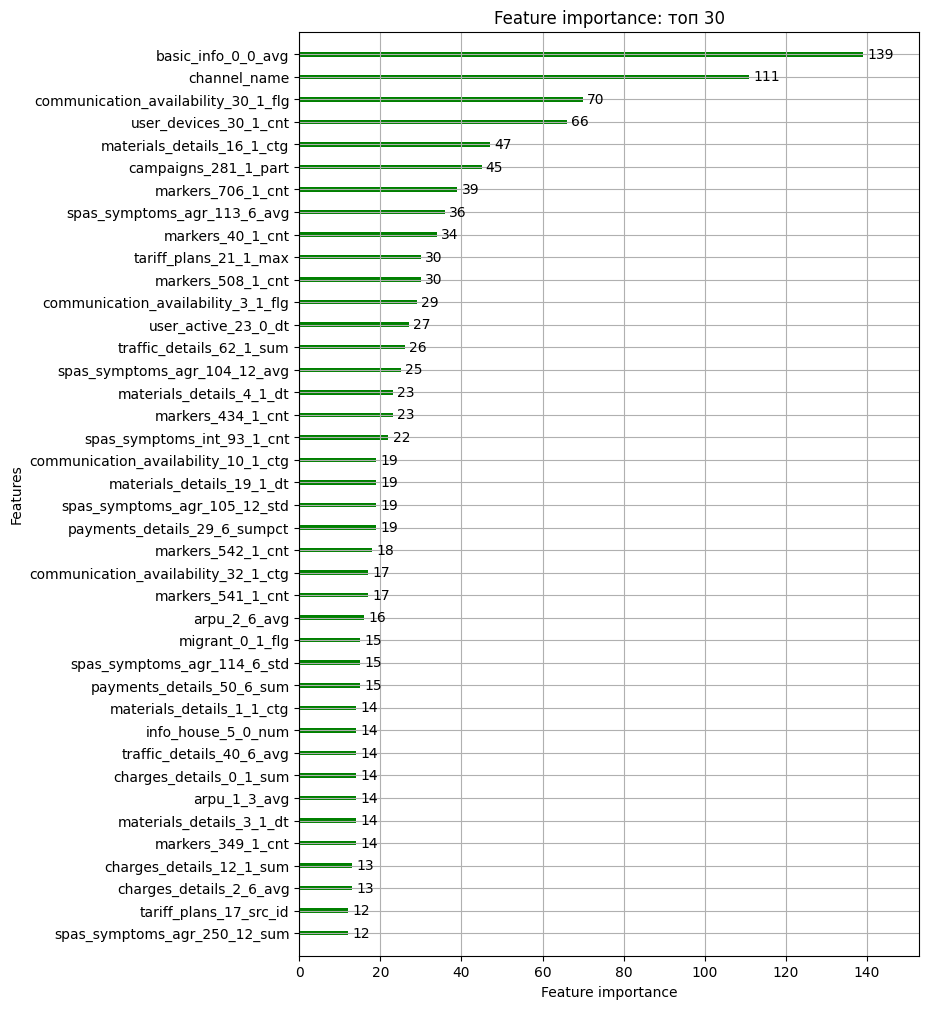

In [19]:
lgb.plot_importance(booster_1, figsize=(8,12),max_num_features=40,color='green')
plt.title('Feature importance: топ 30')
plt.show()

### Выгрузка важных признаков первой итерации

In [20]:
%%time
#число загружаемых строк
n_rows=800000
fe_0=pd.read_csv('fe_0.csv')
#импорт части тренировочных данных из общего датасета
df_train=pd.read_parquet('/kaggle/input/r1-hack/dataset_train.parquet',columns=['target']+list(fe_0.iloc[:,0]))
df_train=reduce_mem_usage(df_train)
target=df_train['target']
df_train=df_train.drop(columns=['target'])


Memory usage of dataframe is 1979.89 MB
Memory usage after optimization is: 496.81 MB
Decreased by 74.9%
CPU times: user 13.7 s, sys: 7.55 s, total: 21.2 s
Wall time: 14.7 s


In [21]:
%%time
#выборка строк
N=800000
features=df_train[:N]
target=target[:N]

#применение функции уменьшения класса к увеличенному классу
features_downsampled, target_downsampled = downsample(features, target, 0.05)
#проверка соотношения классов
print('размер оубчающей выборки:',features.shape)
print('баланс классов:', target_downsampled.mean())
print('')
print('размер даунсемпловой выборки:',features_downsampled.shape)



#разделение выборок
X_train, X_test, y_train, y_test= train_test_split(features_downsampled,
                                                   target_downsampled, 
                                                   test_size=.2,random_state=234,
                                                   stratify=target_downsampled)

размер оубчающей выборки: (702086, 377)
баланс классов: 0.13570719602977668

размер даунсемпловой выборки: (40300, 377)
CPU times: user 3.03 s, sys: 159 µs, total: 3.03 s
Wall time: 3.03 s


In [22]:
%%time
#это была не первая итерация всех этих действий, потому гиперпараметры уже подобраны
booster_1 = lgb.LGBMClassifier(learning_rate=0.02,
                             num_leaves=13,
                             max_depth=7,
                             max_bin=120,
                             num_iterations=400,
                             random_state=234)
booster_1.fit(X_train, y_train, eval_set=[(X_test, y_test),],
            eval_metric='auc',
            early_stopping_rounds=6)
y_pred_lgbm=booster_1.predict_proba(X_test)
y_pred_lgbm=y_pred_lgbm[:,1]
print('lgbm:',roc_auc_score(y_test, y_pred_lgbm))

[1]	valid_0's auc: 0.730859	valid_0's binary_logloss: 0.395311
[2]	valid_0's auc: 0.737899	valid_0's binary_logloss: 0.393501
[3]	valid_0's auc: 0.739075	valid_0's binary_logloss: 0.391782
[4]	valid_0's auc: 0.741162	valid_0's binary_logloss: 0.390153
[5]	valid_0's auc: 0.740949	valid_0's binary_logloss: 0.388669
[6]	valid_0's auc: 0.740609	valid_0's binary_logloss: 0.387267
[7]	valid_0's auc: 0.74153	valid_0's binary_logloss: 0.385773
[8]	valid_0's auc: 0.744061	valid_0's binary_logloss: 0.384492
[9]	valid_0's auc: 0.744131	valid_0's binary_logloss: 0.383201
[10]	valid_0's auc: 0.743947	valid_0's binary_logloss: 0.382019
[11]	valid_0's auc: 0.7445	valid_0's binary_logloss: 0.380827
[12]	valid_0's auc: 0.744364	valid_0's binary_logloss: 0.379737
[13]	valid_0's auc: 0.74995	valid_0's binary_logloss: 0.378645
[14]	valid_0's auc: 0.754799	valid_0's binary_logloss: 0.377686
[15]	valid_0's auc: 0.75456	valid_0's binary_logloss: 0.376727
[16]	valid_0's auc: 0.753731	valid_0's binary_logloss:

## Модель CatBoost

CatBoost сделали с несколькими уточнениями по предобработке, а также показываем вариант сразу с отобранными уже фичами (подгружаем их).

Модель построена на уменьшенном количестве признаков. Признаки отбирались catboost select_features с функцией потерь - кроссэнтропия.

NB: признаки с маркером dt (2 шт) имеют тип float.

In [23]:
#загрузка отобранных признаков
considered_features = list(pd.read_csv('/kaggle/input/united-features-fin/united_features_132.csv')['name'].values)
len(considered_features)

132

In [24]:
#загрузка данных
df = pd.read_parquet('/kaggle/input/r1-hack/dataset_train.parquet', columns = considered_features + ['target'])


In [25]:
#разделение выборок на трейн и тест
df, tdf = train_test_split(df, test_size=60000, random_state=234)

Среди категориальных признаков (ctg, flg) есть 2 у которых значения типа float, они исключены из рассмотрения как категориальные, хотя их значения дискретны

In [26]:
#создание списка категориальных признаков, который передаем catboost'у.
categorical_features = []

for item in df.columns:
    if 'ctg' in item or 'flg' in item:
        categorical_features.append(item)
        
len(categorical_features)

17

In [27]:
#заполнение пропусков значением -1 для каегорий
for item in categorical_features:
    df[item] = df[item].fillna(-1)
    tdf[item] = tdf[item].fillna(-1)

In [28]:
#вывод информации об отобранных категориальных признаках методом info()
df[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 642086 entries, 177703 to 321439
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   communication_availability_3_1_flg   642086 non-null  int32
 1   communication_availability_4_1_flg   642086 non-null  int32
 2   communication_availability_15_1_flg  642086 non-null  int32
 3   communication_availability_28_1_flg  642086 non-null  int32
 4   communication_availability_30_1_flg  642086 non-null  int32
 5   communication_availability_33_1_flg  642086 non-null  int32
 6   scheme_types_2_1_flg                 642086 non-null  int32
 7   communication_availability_39_1_flg  642086 non-null  int32
 8   communication_availability_45_1_flg  642086 non-null  int32
 9   communication_availability_46_1_flg  642086 non-null  int32
 10  communication_availability_49_1_flg  642086 non-null  int32
 11  communication_availability_52_1_flg  64

In [29]:
#сокращение используемой памяти
df = reduce_mem_usage(df)
tdf = reduce_mem_usage(tdf)

Memory usage of dataframe is 617.24 MB
Memory usage after optimization is: 161.05 MB
Decreased by 73.9%
Memory usage of dataframe is 57.68 MB
Memory usage after optimization is: 15.05 MB
Decreased by 73.9%


In [30]:
#вылделение таргета
X_train = df.drop(columns=['target'])
y_train = df['target']

X_test = tdf.drop(columns=['target'])
y_test = tdf['target']

In [31]:
#Обучение модели с подобранными параметрами
%%time
model = CatBoostClassifier(
                    logging_level='Silent',
                    loss_function = 'Logloss',
                    border_count= 32,
                    random_seed=234,
                    custom_loss='AUC',
                    cat_features = categorical_features,
    depth= 4,
    l2_leaf_reg = 50,
    learning_rate = 0.2,
    feature_border_type = 'MinEntropy'
    )

model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.7497317730362174

# Финальная модель

В итоге лучше всех себя показала просто модель LGBM.

In [32]:

booster_fin = lgb.LGBMClassifier(learning_rate=0.02,
                             num_leaves=13,
                             max_depth=7,
                             max_bin=200,
                             num_iterations=400,
                             random_state=234)
booster_fin.fit(features_downsampled,target_downsampled)



LGBMClassifier(learning_rate=0.02, max_bin=200, max_depth=7, num_iterations=400,
               num_leaves=13, random_state=234)

# Test

In [33]:
#загрузка тестовых признаков
features_test = pd.read_parquet('/kaggle/input/r1-hack/features_oot.parquet',columns=list(fe_0.iloc[:,0]))

In [35]:

features_test['channel_name']=features_test['channel_name'].astype('category')

In [36]:
#предсказание и запись в файл
answers = booster_fin.predict_proba(features_test)[:, 1]
submission = pd.DataFrame(answers,
                          index = features_test.index,
                          columns = ['target'])
submission.index.name = 'id'
submission.to_csv('submission.csv')
pd.read_csv('submission.csv')

,id,target
0,0,0.262684
1,1,0.222454
2,2,0.264748
3,3,0.179777
4,4,0.353911
...,...,...
60656,60656,0.178641
60657,60657,0.275184
60658,60658,0.250564
60659,60659,0.290863


## 

# Выводы

Были опробованы следующие подходы:

* Обработка числовых данных преобразователями StandardScaler, MinMax, Qantile (из sklearn preprocessing)
* Заполнение пропусков KNNImputer-ом, а также медианными значениями
* Отбрасывание выбросов больше 1.5 межквантильного размаха
* Обучение моделей Логистической Регрессии, Случайного леса
* Подбор гиперпараметров встроенными методами и GridSearchCV (не привели в отчёте)
* Объединение LGBM и CatBoost в ансамбль Stacking Classifier.

Во всех случаях итоговая метрика падала, более того: самая лучшая модель на кеггловских данных у нас получилась lgbm на всех параметрах, до отбора feature_importance.

Наиболее интересно было попробовать ансамбль этих моделей, но мы не успели:)